# Figures 5-6 and S. Figures 1-4 (Molina et al., in prep.) 

## Imports

In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import xskillscore as xs

import som_analysis
import cluster_analysis
import narm_analysis

In [2]:
mpl.rcParams['hatch.linewidth'] = 0.3

## functions

In [3]:
def add_insetmap(axes_extent, map_extent, lons, lats, temp_data, 
                 vmin, vmax, cmap='coolwarm'):
    
    use_projection = ccrs.Mercator()     # preserve shape well
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))
    
    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    
    sub_ax.set_extent(map_extent, geodetic)  # map extents
    sub_ax.coastlines(linewidth=0.35, zorder=10)
    
    sub_ax.pcolormesh(lons, lats, temp_data, transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax, cmap=cmap)

    extent_box = sgeom.box(map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries([extent_box], ccrs.PlateCarree(), color='none', linewidth=0.05)

In [4]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month>=mo_init) | (dt_array.month<=mo_end), True, False)

## open data

In [5]:
ds_t2m = xr.open_dataset('/glade/scratch/molina/s2s/bootstrap/t2m_week34_wxregimes.nc')
ds_pr  = xr.open_dataset('/glade/scratch/molina/s2s/bootstrap/pr_week34_wxregimes.nc')

## states data

In [6]:
# load states for plotting
reader = shpreader.Reader(
    f'/glade/work/molina/DATA/cartopy_usstates/ne_50m_admin_1_states_provinces_lines.shp')
states = list(reader.geometries())
STATES = cfeature.ShapelyFeature(states, ccrs.PlateCarree())

## figure 5

/glade/scratch/molina/ipykernel_96037/3322337184.py:395: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


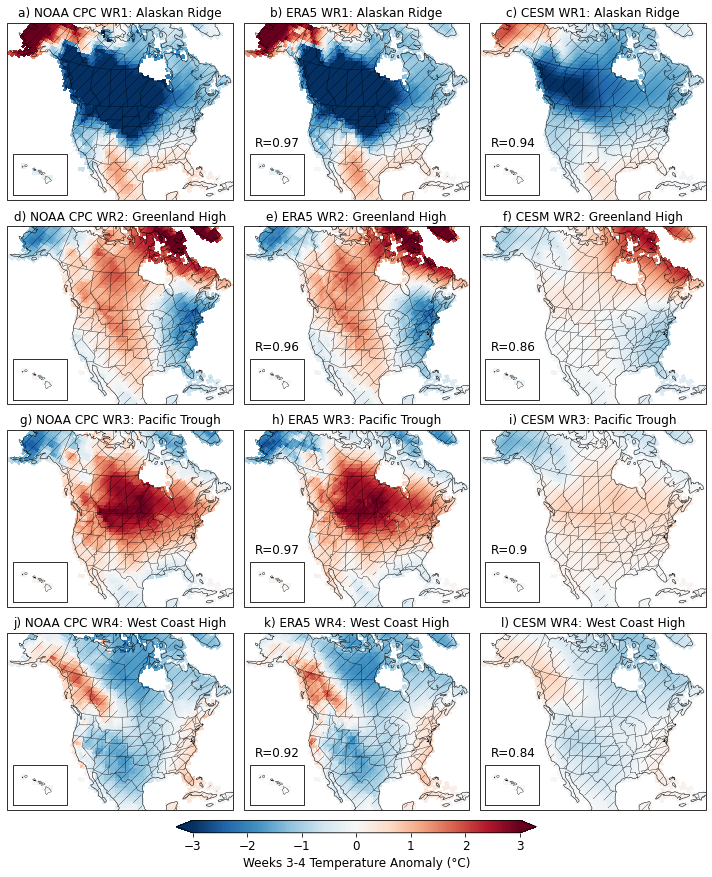

In [7]:
vmin=-3
vmax=3

proj = ccrs.LambertConformal(central_latitude = 39, 
                             central_longitude = -105, 
                             standard_parallels = (33, 45))

lons, lats = np.meshgrid(ds_t2m['lon'].values, ds_t2m['lat'].values)

# ---

fig, axs = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(10,11.5))

# ---

pm = axs[0][0].pcolormesh(lons, lats, ds_t2m['wr1_ncpc'].values, 
                          transform=ccrs.PlateCarree(), 
                          vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][0].contourf(lons, lats, np.where((
    ds_t2m['wr1_ncpc'].values<=ds_t2m['wr1_ncpc_005'].values)|(
    ds_t2m['wr1_ncpc'].values>=ds_t2m['wr1_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][0].set_title(f'a) NOAA CPC WR1: Alaskan Ridge', fontsize=12)
axs[0][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[1][0].pcolormesh(lons, lats, ds_t2m['wr2_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][0].contourf(lons, lats, np.where((
    ds_t2m['wr2_ncpc'].values<=ds_t2m['wr2_ncpc_005'].values)|(
    ds_t2m['wr2_ncpc'].values>=ds_t2m['wr2_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][0].set_title(f'd) NOAA CPC WR2: Greenland High', fontsize=12)
axs[1][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[2][0].pcolormesh(lons, lats, ds_t2m['wr3_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][0].contourf(lons, lats, np.where((
    ds_t2m['wr3_ncpc'].values<=ds_t2m['wr3_ncpc_005'].values)|(
    ds_t2m['wr3_ncpc'].values>=ds_t2m['wr3_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][0].set_title(f'g) NOAA CPC WR3: Pacific Trough', fontsize=12)
axs[2][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[3][0].pcolormesh(lons, lats, ds_t2m['wr4_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][0].contourf(lons, lats, np.where((
    ds_t2m['wr4_ncpc'].values<=ds_t2m['wr4_ncpc_005'].values)|(
    ds_t2m['wr4_ncpc'].values>=ds_t2m['wr4_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][0].set_title(f'j) NOAA CPC WR4: West Coast High', fontsize=12)
axs[3][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[0][1].pcolormesh(lons, lats, ds_t2m['wr1_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][1].contourf(lons, lats, np.where((
    ds_t2m['wr1_era5'].values<=ds_t2m['wr1_era5_005'].values)|(
    ds_t2m['wr1_era5'].values>=ds_t2m['wr1_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][1].set_title(f'b) ERA5 WR1: Alaskan Ridge', fontsize=12)
axs[0][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr1_era5'].values.flatten()[~np.isnan(ds_t2m['wr1_era5'].values.flatten())], 
        ds_t2m['wr1_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr1_ncpc'].values.flatten())])[0],2)

axs[0][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][1].pcolormesh(lons, lats, ds_t2m['wr2_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][1].contourf(lons, lats, np.where((
    ds_t2m['wr2_era5'].values<=ds_t2m['wr2_era5_005'].values)|(
    ds_t2m['wr2_era5'].values>=ds_t2m['wr2_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][1].set_title(f'e) ERA5 WR2: Greenland High', fontsize=12)
axs[1][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr2_era5'].values.flatten()[~np.isnan(ds_t2m['wr2_era5'].values.flatten())], 
        ds_t2m['wr2_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr2_ncpc'].values.flatten())])[0],2)

axs[1][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][1].pcolormesh(lons, lats, ds_t2m['wr3_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][1].contourf(lons, lats, np.where((
    ds_t2m['wr3_era5'].values<=ds_t2m['wr3_era5_005'].values)|(
    ds_t2m['wr3_era5'].values>=ds_t2m['wr3_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][1].set_title(f'h) ERA5 WR3: Pacific Trough', fontsize=12)
axs[2][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr3_era5'].values.flatten()[~np.isnan(ds_t2m['wr3_era5'].values.flatten())], 
        ds_t2m['wr3_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr3_ncpc'].values.flatten())])[0],2)

axs[2][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][1].pcolormesh(lons, lats, ds_t2m['wr4_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][1].contourf(lons, lats, np.where((
    ds_t2m['wr4_era5'].values<=ds_t2m['wr4_era5_005'].values)|(
    ds_t2m['wr4_era5'].values>=ds_t2m['wr4_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][1].set_title(f'k) ERA5 WR4: West Coast High', fontsize=12)
axs[3][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr4_era5'].values.flatten()[~np.isnan(ds_t2m['wr4_era5'].values.flatten())], 
        ds_t2m['wr4_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr4_ncpc'].values.flatten())])[0],2)

axs[3][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[0][2].pcolormesh(lons, lats, ds_t2m['wr1_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][2].contourf(lons, lats, np.where((
    ds_t2m['wr1_cesm'].values<=ds_t2m['wr1_cesm_005'].values)|(
    ds_t2m['wr1_cesm'].values>=ds_t2m['wr1_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][2].set_title(f'c) CESM WR1: Alaskan Ridge', fontsize=12)
axs[0][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr1_era5'].values.flatten()[~np.isnan(ds_t2m['wr1_era5'].values.flatten())], 
        ds_t2m['wr1_cesm'].values.flatten()[~np.isnan(ds_t2m['wr1_cesm'].values.flatten())])[0],2)

axs[0][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][2].pcolormesh(lons, lats, ds_t2m['wr2_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][2].contourf(lons, lats, np.where((
    ds_t2m['wr2_cesm'].values<=ds_t2m['wr2_cesm_005'].values)|(
    ds_t2m['wr2_cesm'].values>=ds_t2m['wr2_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][2].set_title(f'f) CESM WR2: Greenland High', fontsize=12)
axs[1][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr2_era5'].values.flatten()[~np.isnan(ds_t2m['wr2_era5'].values.flatten())], 
        ds_t2m['wr2_cesm'].values.flatten()[~np.isnan(ds_t2m['wr2_cesm'].values.flatten())])[0],2)

axs[1][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][2].pcolormesh(lons, lats, ds_t2m['wr3_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][2].contourf(lons, lats, np.where((
    ds_t2m['wr3_cesm'].values<=ds_t2m['wr3_cesm_005'].values)|(
    ds_t2m['wr3_cesm'].values>=ds_t2m['wr3_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][2].set_title(f'i) CESM WR3: Pacific Trough', fontsize=12)
axs[2][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr3_era5'].values.flatten()[~np.isnan(ds_t2m['wr3_era5'].values.flatten())], 
        ds_t2m['wr3_cesm'].values.flatten()[~np.isnan(ds_t2m['wr3_cesm'].values.flatten())])[0],2)

axs[2][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][2].pcolormesh(lons, lats, ds_t2m['wr4_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][2].contourf(lons, lats, np.where((
    ds_t2m['wr4_cesm'].values<=ds_t2m['wr4_cesm_005'].values)|(
    ds_t2m['wr4_cesm'].values>=ds_t2m['wr4_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][2].set_title(f'l) CESM WR4: West Coast High', fontsize=12)
axs[3][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr4_era5'].values.flatten()[~np.isnan(ds_t2m['wr4_era5'].values.flatten())], 
        ds_t2m['wr4_cesm'].values.flatten()[~np.isnan(ds_t2m['wr4_cesm'].values.flatten())])[0],2)

axs[3][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

cbar_ax = fig.add_axes([0.25, -0.01, 0.5, 0.015])

ticks_1 = [-3,-2,-1,0,1,2,3]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 3-4 Temperature Anomaly (\N{DEGREE SIGN}C)', fontsize=12)

# ---

plt.tight_layout()
plt.savefig(f"fig_wk34_tk.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

## figure 6

/glade/scratch/molina/ipykernel_96037/2067576740.py:435: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


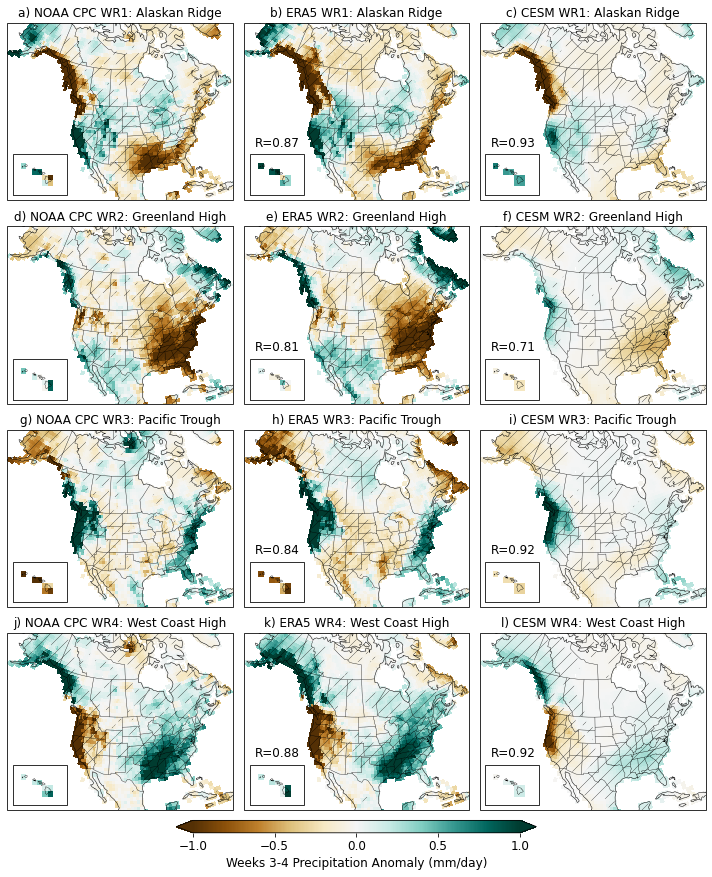

In [8]:
vmin=-1
vmax=1

proj = ccrs.LambertConformal(central_latitude = 39, 
                             central_longitude = -105, 
                             standard_parallels = (33, 45))

lons, lats = np.meshgrid(ds_pr['lon'].values, ds_pr['lat'].values)

# ---

fig, axs = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(10,11.5))

# ---

pm = axs[0][0].pcolormesh(lons, lats, ds_pr['wr1_ncpc'].values, 
                          transform=ccrs.PlateCarree(), 
                          vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][0].contourf(lons, lats, np.where((
    ds_pr['wr1_ncpc'].values<=ds_pr['wr1_ncpc_005'].values)|(
    ds_pr['wr1_ncpc'].values>=ds_pr['wr1_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][0].set_title(f'a) NOAA CPC WR1: Alaskan Ridge', fontsize=12)
axs[0][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[1][0].pcolormesh(lons, lats, ds_pr['wr2_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][0].contourf(lons, lats, np.where((
    ds_pr['wr2_ncpc'].values<=ds_pr['wr2_ncpc_005'].values)|(
    ds_pr['wr2_ncpc'].values>=ds_pr['wr2_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][0].set_title(f'd) NOAA CPC WR2: Greenland High', fontsize=12)
axs[1][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[2][0].pcolormesh(lons, lats, ds_pr['wr3_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][0].contourf(lons, lats, np.where((
    ds_pr['wr3_ncpc'].values<=ds_pr['wr3_ncpc_005'].values)|(
    ds_pr['wr3_ncpc'].values>=ds_pr['wr3_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][0].set_title(f'g) NOAA CPC WR3: Pacific Trough', fontsize=12)
axs[2][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[3][0].pcolormesh(lons, lats, ds_pr['wr4_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][0].contourf(lons, lats, np.where((
    ds_pr['wr4_ncpc'].values<=ds_pr['wr4_ncpc_005'].values)|(
    ds_pr['wr4_ncpc'].values>=ds_pr['wr4_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][0].set_title(f'j) NOAA CPC WR4: West Coast High', fontsize=12)
axs[3][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[0][1].pcolormesh(lons, lats, ds_pr['wr1_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][1].contourf(lons, lats, np.where((
    ds_pr['wr1_era5'].values<=ds_pr['wr1_era5_005'].values)|(
    ds_pr['wr1_era5'].values>=ds_pr['wr1_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][1].set_title(f'b) ERA5 WR1: Alaskan Ridge', fontsize=12)
axs[0][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr1_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr1_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr1_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[0][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][1].pcolormesh(lons, lats, ds_pr['wr2_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][1].contourf(lons, lats, np.where((
    ds_pr['wr2_era5'].values<=ds_pr['wr2_era5_005'].values)|(
    ds_pr['wr2_era5'].values>=ds_pr['wr2_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][1].set_title(f'e) ERA5 WR2: Greenland High', fontsize=12)
axs[1][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr2_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr2_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr2_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[1][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][1].pcolormesh(lons, lats, ds_pr['wr3_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][1].contourf(lons, lats, np.where((
    ds_pr['wr3_era5'].values<=ds_pr['wr3_era5_005'].values)|(
    ds_pr['wr3_era5'].values>=ds_pr['wr3_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][1].set_title(f'h) ERA5 WR3: Pacific Trough', fontsize=12)
axs[2][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr3_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr3_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr3_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[2][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][1].pcolormesh(lons, lats, ds_pr['wr4_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][1].contourf(lons, lats, np.where((
    ds_pr['wr4_era5'].values<=ds_pr['wr4_era5_005'].values)|(
    ds_pr['wr4_era5'].values>=ds_pr['wr4_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][1].set_title(f'k) ERA5 WR4: West Coast High', fontsize=12)
axs[3][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr4_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr4_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr4_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[3][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[0][2].pcolormesh(lons, lats, ds_pr['wr1_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][2].contourf(lons, lats, np.where((
    ds_pr['wr1_cesm'].values<=ds_pr['wr1_cesm_005'].values)|(
    ds_pr['wr1_cesm'].values>=ds_pr['wr1_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][2].set_title(f'c) CESM WR1: Alaskan Ridge', fontsize=12)
axs[0][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr1_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr1_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr1_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[0][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][2].pcolormesh(lons, lats, ds_pr['wr2_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][2].contourf(lons, lats, np.where((
    ds_pr['wr2_cesm'].values<=ds_pr['wr2_cesm_005'].values)|(
    ds_pr['wr2_cesm'].values>=ds_pr['wr2_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][2].set_title(f'f) CESM WR2: Greenland High', fontsize=12)
axs[1][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr2_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr2_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr2_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[1][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][2].pcolormesh(lons, lats, ds_pr['wr3_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][2].contourf(lons, lats, np.where((
    ds_pr['wr3_cesm'].values<=ds_pr['wr3_cesm_005'].values)|(
    ds_pr['wr3_cesm'].values>=ds_pr['wr3_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][2].set_title(f'i) CESM WR3: Pacific Trough', fontsize=12)
axs[2][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr3_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr3_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr3_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[2][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][2].pcolormesh(lons, lats, ds_pr['wr4_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][2].contourf(lons, lats, np.where((
    ds_pr['wr4_cesm'].values<=ds_pr['wr4_cesm_005'].values)|(
    ds_pr['wr4_cesm'].values>=ds_pr['wr4_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][2].set_title(f'l) CESM WR4: West Coast High', fontsize=12)
axs[3][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr4_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr4_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr4_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[3][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

cbar_ax = fig.add_axes([0.25, -0.01, 0.5, 0.015])

ticks_1 = [-1,-0.5,0,0.5,1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Weeks 3-4 Precipitation Anomaly (mm/day)', fontsize=12)

# ---

plt.tight_layout()
plt.savefig(f"fig_wk34_pr.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

## open data for supplementary figs

In [9]:
ds_t2m = xr.open_dataset('/glade/scratch/molina/s2s/bootstrap/t2m_week12_wxregimes.nc')
ds_pr  = xr.open_dataset('/glade/scratch/molina/s2s/bootstrap/pr_week12_wxregimes.nc')

## Supplementary Figure 1

/glade/scratch/molina/ipykernel_96037/3870488612.py:395: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


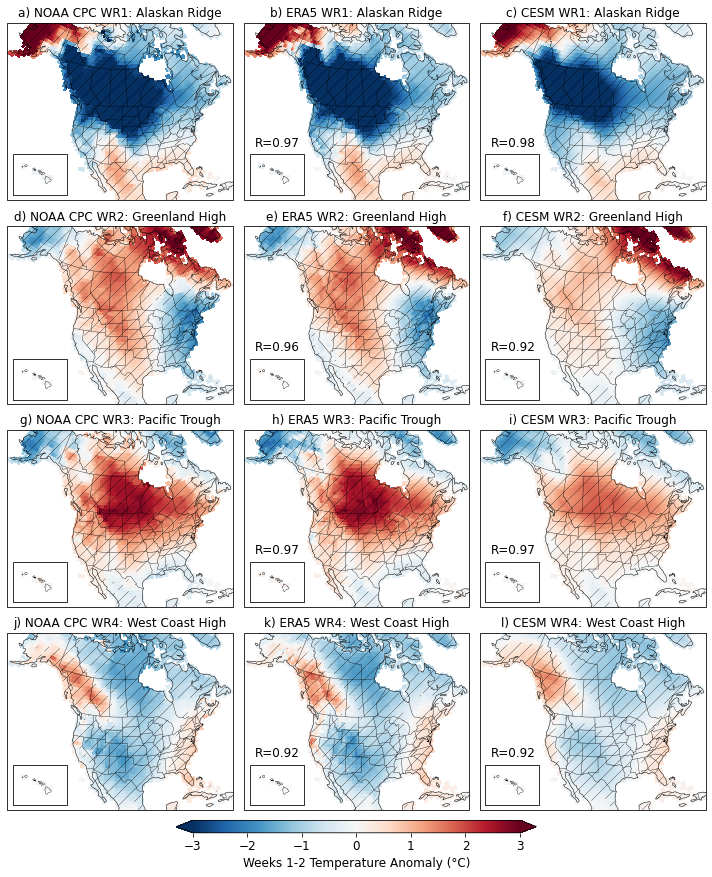

In [10]:
vmin=-3
vmax=3

proj = ccrs.LambertConformal(central_latitude = 39, 
                             central_longitude = -105, 
                             standard_parallels = (33, 45))

lons, lats = np.meshgrid(ds_t2m['lon'].values, ds_t2m['lat'].values)

# ---

fig, axs = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(10,11.5))

# ---

pm = axs[0][0].pcolormesh(lons, lats, ds_t2m['wr1_ncpc'].values, 
                          transform=ccrs.PlateCarree(), 
                          vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][0].contourf(lons, lats, np.where((
    ds_t2m['wr1_ncpc'].values<=ds_t2m['wr1_ncpc_005'].values)|(
    ds_t2m['wr1_ncpc'].values>=ds_t2m['wr1_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][0].set_title(f'a) NOAA CPC WR1: Alaskan Ridge', fontsize=12)
axs[0][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[1][0].pcolormesh(lons, lats, ds_t2m['wr2_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][0].contourf(lons, lats, np.where((
    ds_t2m['wr2_ncpc'].values<=ds_t2m['wr2_ncpc_005'].values)|(
    ds_t2m['wr2_ncpc'].values>=ds_t2m['wr2_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][0].set_title(f'd) NOAA CPC WR2: Greenland High', fontsize=12)
axs[1][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[2][0].pcolormesh(lons, lats, ds_t2m['wr3_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][0].contourf(lons, lats, np.where((
    ds_t2m['wr3_ncpc'].values<=ds_t2m['wr3_ncpc_005'].values)|(
    ds_t2m['wr3_ncpc'].values>=ds_t2m['wr3_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][0].set_title(f'g) NOAA CPC WR3: Pacific Trough', fontsize=12)
axs[2][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[3][0].pcolormesh(lons, lats, ds_t2m['wr4_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][0].contourf(lons, lats, np.where((
    ds_t2m['wr4_ncpc'].values<=ds_t2m['wr4_ncpc_005'].values)|(
    ds_t2m['wr4_ncpc'].values>=ds_t2m['wr4_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][0].set_title(f'j) NOAA CPC WR4: West Coast High', fontsize=12)
axs[3][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[0][1].pcolormesh(lons, lats, ds_t2m['wr1_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][1].contourf(lons, lats, np.where((
    ds_t2m['wr1_era5'].values<=ds_t2m['wr1_era5_005'].values)|(
    ds_t2m['wr1_era5'].values>=ds_t2m['wr1_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][1].set_title(f'b) ERA5 WR1: Alaskan Ridge', fontsize=12)
axs[0][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr1_era5'].values.flatten()[~np.isnan(ds_t2m['wr1_era5'].values.flatten())], 
        ds_t2m['wr1_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr1_ncpc'].values.flatten())])[0],2)

axs[0][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][1].pcolormesh(lons, lats, ds_t2m['wr2_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][1].contourf(lons, lats, np.where((
    ds_t2m['wr2_era5'].values<=ds_t2m['wr2_era5_005'].values)|(
    ds_t2m['wr2_era5'].values>=ds_t2m['wr2_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][1].set_title(f'e) ERA5 WR2: Greenland High', fontsize=12)
axs[1][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr2_era5'].values.flatten()[~np.isnan(ds_t2m['wr2_era5'].values.flatten())], 
        ds_t2m['wr2_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr2_ncpc'].values.flatten())])[0],2)

axs[1][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][1].pcolormesh(lons, lats, ds_t2m['wr3_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][1].contourf(lons, lats, np.where((
    ds_t2m['wr3_era5'].values<=ds_t2m['wr3_era5_005'].values)|(
    ds_t2m['wr3_era5'].values>=ds_t2m['wr3_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][1].set_title(f'h) ERA5 WR3: Pacific Trough', fontsize=12)
axs[2][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr3_era5'].values.flatten()[~np.isnan(ds_t2m['wr3_era5'].values.flatten())], 
        ds_t2m['wr3_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr3_ncpc'].values.flatten())])[0],2)

axs[2][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][1].pcolormesh(lons, lats, ds_t2m['wr4_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][1].contourf(lons, lats, np.where((
    ds_t2m['wr4_era5'].values<=ds_t2m['wr4_era5_005'].values)|(
    ds_t2m['wr4_era5'].values>=ds_t2m['wr4_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][1].set_title(f'k) ERA5 WR4: West Coast High', fontsize=12)
axs[3][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr4_era5'].values.flatten()[~np.isnan(ds_t2m['wr4_era5'].values.flatten())], 
        ds_t2m['wr4_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr4_ncpc'].values.flatten())])[0],2)

axs[3][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[0][2].pcolormesh(lons, lats, ds_t2m['wr1_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][2].contourf(lons, lats, np.where((
    ds_t2m['wr1_cesm'].values<=ds_t2m['wr1_cesm_005'].values)|(
    ds_t2m['wr1_cesm'].values>=ds_t2m['wr1_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][2].set_title(f'c) CESM WR1: Alaskan Ridge', fontsize=12)
axs[0][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr1_era5'].values.flatten()[~np.isnan(ds_t2m['wr1_era5'].values.flatten())], 
        ds_t2m['wr1_cesm'].values.flatten()[~np.isnan(ds_t2m['wr1_cesm'].values.flatten())])[0],2)

axs[0][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][2].pcolormesh(lons, lats, ds_t2m['wr2_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][2].contourf(lons, lats, np.where((
    ds_t2m['wr2_cesm'].values<=ds_t2m['wr2_cesm_005'].values)|(
    ds_t2m['wr2_cesm'].values>=ds_t2m['wr2_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][2].set_title(f'f) CESM WR2: Greenland High', fontsize=12)
axs[1][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr2_era5'].values.flatten()[~np.isnan(ds_t2m['wr2_era5'].values.flatten())], 
        ds_t2m['wr2_cesm'].values.flatten()[~np.isnan(ds_t2m['wr2_cesm'].values.flatten())])[0],2)

axs[1][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][2].pcolormesh(lons, lats, ds_t2m['wr3_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][2].contourf(lons, lats, np.where((
    ds_t2m['wr3_cesm'].values<=ds_t2m['wr3_cesm_005'].values)|(
    ds_t2m['wr3_cesm'].values>=ds_t2m['wr3_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][2].set_title(f'i) CESM WR3: Pacific Trough', fontsize=12)
axs[2][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr3_era5'].values.flatten()[~np.isnan(ds_t2m['wr3_era5'].values.flatten())], 
        ds_t2m['wr3_cesm'].values.flatten()[~np.isnan(ds_t2m['wr3_cesm'].values.flatten())])[0],2)

axs[2][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][2].pcolormesh(lons, lats, ds_t2m['wr4_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][2].contourf(lons, lats, np.where((
    ds_t2m['wr4_cesm'].values<=ds_t2m['wr4_cesm_005'].values)|(
    ds_t2m['wr4_cesm'].values>=ds_t2m['wr4_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][2].set_title(f'l) CESM WR4: West Coast High', fontsize=12)
axs[3][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr4_era5'].values.flatten()[~np.isnan(ds_t2m['wr4_era5'].values.flatten())], 
        ds_t2m['wr4_cesm'].values.flatten()[~np.isnan(ds_t2m['wr4_cesm'].values.flatten())])[0],2)

axs[3][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

cbar_ax = fig.add_axes([0.25, -0.01, 0.5, 0.015])

ticks_1 = [-3,-2,-1,0,1,2,3]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 1-2 Temperature Anomaly (\N{DEGREE SIGN}C)', fontsize=12)

# ---

plt.tight_layout()
plt.savefig(f"fig_wk12_tk.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

## Supplementary Figure 2

/glade/scratch/molina/ipykernel_96037/1616286908.py:435: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


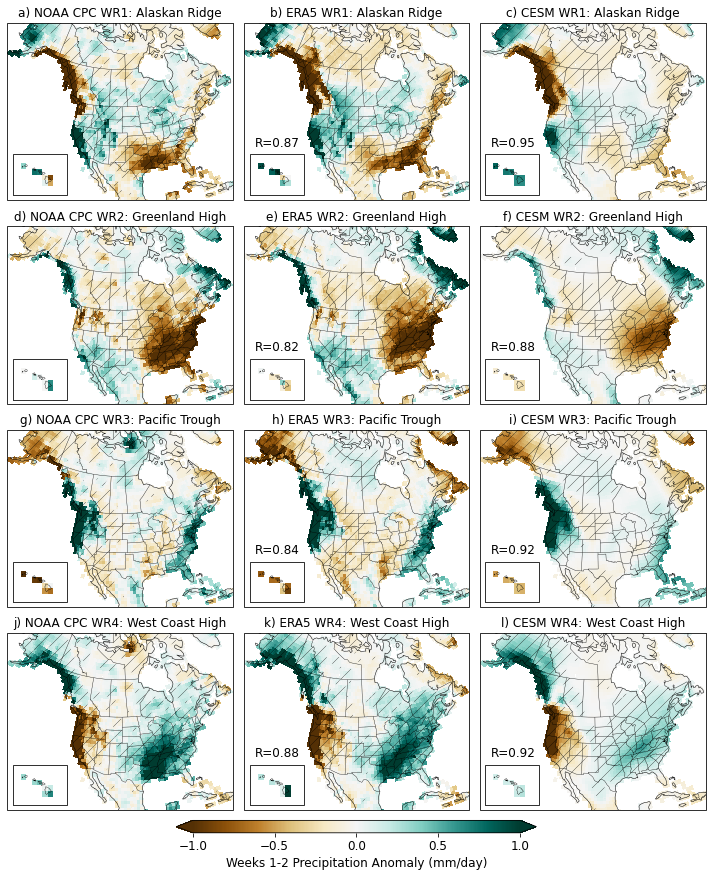

In [11]:
vmin=-1
vmax=1

proj = ccrs.LambertConformal(central_latitude = 39, 
                             central_longitude = -105, 
                             standard_parallels = (33, 45))

lons, lats = np.meshgrid(ds_pr['lon'].values, ds_pr['lat'].values)

# ---

fig, axs = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(10,11.5))

# ---

pm = axs[0][0].pcolormesh(lons, lats, ds_pr['wr1_ncpc'].values, 
                          transform=ccrs.PlateCarree(), 
                          vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][0].contourf(lons, lats, np.where((
    ds_pr['wr1_ncpc'].values<=ds_pr['wr1_ncpc_005'].values)|(
    ds_pr['wr1_ncpc'].values>=ds_pr['wr1_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][0].set_title(f'a) NOAA CPC WR1: Alaskan Ridge', fontsize=12)
axs[0][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[1][0].pcolormesh(lons, lats, ds_pr['wr2_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][0].contourf(lons, lats, np.where((
    ds_pr['wr2_ncpc'].values<=ds_pr['wr2_ncpc_005'].values)|(
    ds_pr['wr2_ncpc'].values>=ds_pr['wr2_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][0].set_title(f'd) NOAA CPC WR2: Greenland High', fontsize=12)
axs[1][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[2][0].pcolormesh(lons, lats, ds_pr['wr3_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][0].contourf(lons, lats, np.where((
    ds_pr['wr3_ncpc'].values<=ds_pr['wr3_ncpc_005'].values)|(
    ds_pr['wr3_ncpc'].values>=ds_pr['wr3_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][0].set_title(f'g) NOAA CPC WR3: Pacific Trough', fontsize=12)
axs[2][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[3][0].pcolormesh(lons, lats, ds_pr['wr4_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][0].contourf(lons, lats, np.where((
    ds_pr['wr4_ncpc'].values<=ds_pr['wr4_ncpc_005'].values)|(
    ds_pr['wr4_ncpc'].values>=ds_pr['wr4_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][0].set_title(f'j) NOAA CPC WR4: West Coast High', fontsize=12)
axs[3][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[0][1].pcolormesh(lons, lats, ds_pr['wr1_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][1].contourf(lons, lats, np.where((
    ds_pr['wr1_era5'].values<=ds_pr['wr1_era5_005'].values)|(
    ds_pr['wr1_era5'].values>=ds_pr['wr1_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][1].set_title(f'b) ERA5 WR1: Alaskan Ridge', fontsize=12)
axs[0][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr1_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr1_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr1_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[0][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][1].pcolormesh(lons, lats, ds_pr['wr2_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][1].contourf(lons, lats, np.where((
    ds_pr['wr2_era5'].values<=ds_pr['wr2_era5_005'].values)|(
    ds_pr['wr2_era5'].values>=ds_pr['wr2_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][1].set_title(f'e) ERA5 WR2: Greenland High', fontsize=12)
axs[1][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr2_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr2_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr2_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[1][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][1].pcolormesh(lons, lats, ds_pr['wr3_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][1].contourf(lons, lats, np.where((
    ds_pr['wr3_era5'].values<=ds_pr['wr3_era5_005'].values)|(
    ds_pr['wr3_era5'].values>=ds_pr['wr3_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][1].set_title(f'h) ERA5 WR3: Pacific Trough', fontsize=12)
axs[2][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr3_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr3_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr3_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[2][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][1].pcolormesh(lons, lats, ds_pr['wr4_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][1].contourf(lons, lats, np.where((
    ds_pr['wr4_era5'].values<=ds_pr['wr4_era5_005'].values)|(
    ds_pr['wr4_era5'].values>=ds_pr['wr4_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][1].set_title(f'k) ERA5 WR4: West Coast High', fontsize=12)
axs[3][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr4_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr4_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr4_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[3][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[0][2].pcolormesh(lons, lats, ds_pr['wr1_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][2].contourf(lons, lats, np.where((
    ds_pr['wr1_cesm'].values<=ds_pr['wr1_cesm_005'].values)|(
    ds_pr['wr1_cesm'].values>=ds_pr['wr1_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][2].set_title(f'c) CESM WR1: Alaskan Ridge', fontsize=12)
axs[0][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr1_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr1_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr1_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[0][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][2].pcolormesh(lons, lats, ds_pr['wr2_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][2].contourf(lons, lats, np.where((
    ds_pr['wr2_cesm'].values<=ds_pr['wr2_cesm_005'].values)|(
    ds_pr['wr2_cesm'].values>=ds_pr['wr2_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][2].set_title(f'f) CESM WR2: Greenland High', fontsize=12)
axs[1][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr2_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr2_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr2_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[1][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][2].pcolormesh(lons, lats, ds_pr['wr3_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][2].contourf(lons, lats, np.where((
    ds_pr['wr3_cesm'].values<=ds_pr['wr3_cesm_005'].values)|(
    ds_pr['wr3_cesm'].values>=ds_pr['wr3_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][2].set_title(f'i) CESM WR3: Pacific Trough', fontsize=12)
axs[2][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr3_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr3_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr3_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[2][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][2].pcolormesh(lons, lats, ds_pr['wr4_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][2].contourf(lons, lats, np.where((
    ds_pr['wr4_cesm'].values<=ds_pr['wr4_cesm_005'].values)|(
    ds_pr['wr4_cesm'].values>=ds_pr['wr4_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][2].set_title(f'l) CESM WR4: West Coast High', fontsize=12)
axs[3][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr4_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr4_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr4_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[3][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

cbar_ax = fig.add_axes([0.25, -0.01, 0.5, 0.015])

ticks_1 = [-1,-0.5,0,0.5,1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Weeks 1-2 Precipitation Anomaly (mm/day)', fontsize=12)

# ---

plt.tight_layout()
plt.savefig(f"fig_wk12_pr.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

## open data for supplementary figs

In [12]:
ds_t2m = xr.open_dataset('/glade/scratch/molina/s2s/bootstrap/t2m_week56_wxregimes.nc')
ds_pr  = xr.open_dataset('/glade/scratch/molina/s2s/bootstrap/pr_week56_wxregimes.nc')

## Supplementary Figure 3

/glade/scratch/molina/ipykernel_96037/3598068377.py:395: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


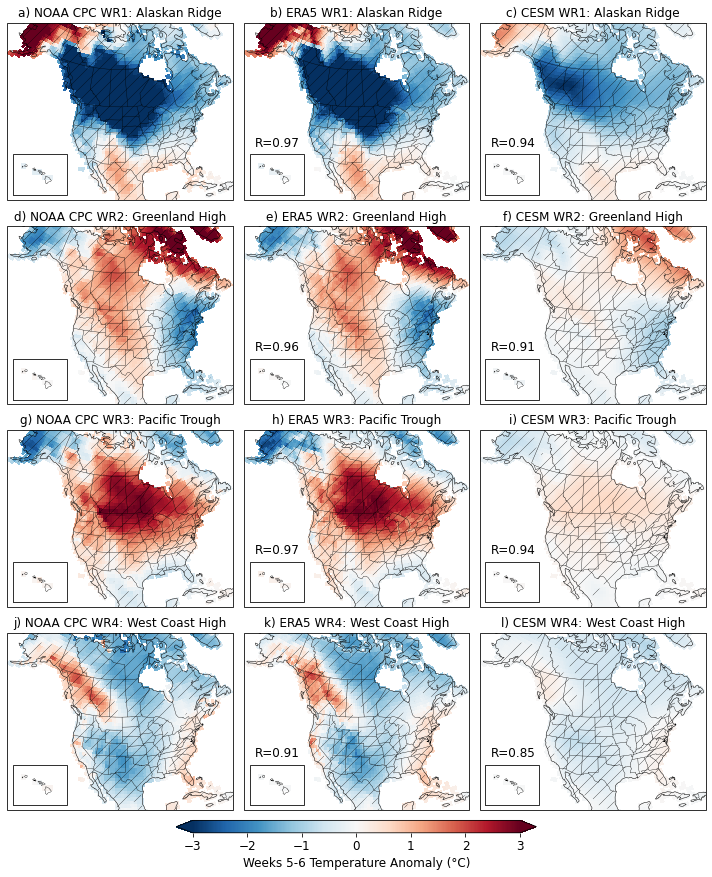

In [13]:
vmin=-3
vmax=3

proj = ccrs.LambertConformal(central_latitude = 39, 
                             central_longitude = -105, 
                             standard_parallels = (33, 45))

lons, lats = np.meshgrid(ds_t2m['lon'].values, ds_t2m['lat'].values)

# ---

fig, axs = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(10,11.5))

# ---

pm = axs[0][0].pcolormesh(lons, lats, ds_t2m['wr1_ncpc'].values, 
                          transform=ccrs.PlateCarree(), 
                          vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][0].contourf(lons, lats, np.where((
    ds_t2m['wr1_ncpc'].values<=ds_t2m['wr1_ncpc_005'].values)|(
    ds_t2m['wr1_ncpc'].values>=ds_t2m['wr1_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][0].set_title(f'a) NOAA CPC WR1: Alaskan Ridge', fontsize=12)
axs[0][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[1][0].pcolormesh(lons, lats, ds_t2m['wr2_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][0].contourf(lons, lats, np.where((
    ds_t2m['wr2_ncpc'].values<=ds_t2m['wr2_ncpc_005'].values)|(
    ds_t2m['wr2_ncpc'].values>=ds_t2m['wr2_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][0].set_title(f'd) NOAA CPC WR2: Greenland High', fontsize=12)
axs[1][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[2][0].pcolormesh(lons, lats, ds_t2m['wr3_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][0].contourf(lons, lats, np.where((
    ds_t2m['wr3_ncpc'].values<=ds_t2m['wr3_ncpc_005'].values)|(
    ds_t2m['wr3_ncpc'].values>=ds_t2m['wr3_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][0].set_title(f'g) NOAA CPC WR3: Pacific Trough', fontsize=12)
axs[2][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[3][0].pcolormesh(lons, lats, ds_t2m['wr4_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][0].contourf(lons, lats, np.where((
    ds_t2m['wr4_ncpc'].values<=ds_t2m['wr4_ncpc_005'].values)|(
    ds_t2m['wr4_ncpc'].values>=ds_t2m['wr4_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][0].set_title(f'j) NOAA CPC WR4: West Coast High', fontsize=12)
axs[3][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

# ---

axs[0][1].pcolormesh(lons, lats, ds_t2m['wr1_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][1].contourf(lons, lats, np.where((
    ds_t2m['wr1_era5'].values<=ds_t2m['wr1_era5_005'].values)|(
    ds_t2m['wr1_era5'].values>=ds_t2m['wr1_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][1].set_title(f'b) ERA5 WR1: Alaskan Ridge', fontsize=12)
axs[0][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr1_era5'].values.flatten()[~np.isnan(ds_t2m['wr1_era5'].values.flatten())], 
        ds_t2m['wr1_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr1_ncpc'].values.flatten())])[0],2)

axs[0][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][1].pcolormesh(lons, lats, ds_t2m['wr2_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][1].contourf(lons, lats, np.where((
    ds_t2m['wr2_era5'].values<=ds_t2m['wr2_era5_005'].values)|(
    ds_t2m['wr2_era5'].values>=ds_t2m['wr2_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][1].set_title(f'e) ERA5 WR2: Greenland High', fontsize=12)
axs[1][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr2_era5'].values.flatten()[~np.isnan(ds_t2m['wr2_era5'].values.flatten())], 
        ds_t2m['wr2_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr2_ncpc'].values.flatten())])[0],2)

axs[1][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][1].pcolormesh(lons, lats, ds_t2m['wr3_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][1].contourf(lons, lats, np.where((
    ds_t2m['wr3_era5'].values<=ds_t2m['wr3_era5_005'].values)|(
    ds_t2m['wr3_era5'].values>=ds_t2m['wr3_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][1].set_title(f'h) ERA5 WR3: Pacific Trough', fontsize=12)
axs[2][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr3_era5'].values.flatten()[~np.isnan(ds_t2m['wr3_era5'].values.flatten())], 
        ds_t2m['wr3_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr3_ncpc'].values.flatten())])[0],2)

axs[2][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][1].pcolormesh(lons, lats, ds_t2m['wr4_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][1].contourf(lons, lats, np.where((
    ds_t2m['wr4_era5'].values<=ds_t2m['wr4_era5_005'].values)|(
    ds_t2m['wr4_era5'].values>=ds_t2m['wr4_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][1].set_title(f'k) ERA5 WR4: West Coast High', fontsize=12)
axs[3][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr4_era5'].values.flatten()[~np.isnan(ds_t2m['wr4_era5'].values.flatten())], 
        ds_t2m['wr4_ncpc'].values.flatten()[~np.isnan(ds_t2m['wr4_ncpc'].values.flatten())])[0],2)

axs[3][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[0][2].pcolormesh(lons, lats, ds_t2m['wr1_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[0][2].contourf(lons, lats, np.where((
    ds_t2m['wr1_cesm'].values<=ds_t2m['wr1_cesm_005'].values)|(
    ds_t2m['wr1_cesm'].values>=ds_t2m['wr1_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][2].set_title(f'c) CESM WR1: Alaskan Ridge', fontsize=12)
axs[0][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr1_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr1_era5'].values.flatten()[~np.isnan(ds_t2m['wr1_era5'].values.flatten())], 
        ds_t2m['wr1_cesm'].values.flatten()[~np.isnan(ds_t2m['wr1_cesm'].values.flatten())])[0],2)

axs[0][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][2].pcolormesh(lons, lats, ds_t2m['wr2_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[1][2].contourf(lons, lats, np.where((
    ds_t2m['wr2_cesm'].values<=ds_t2m['wr2_cesm_005'].values)|(
    ds_t2m['wr2_cesm'].values>=ds_t2m['wr2_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][2].set_title(f'f) CESM WR2: Greenland High', fontsize=12)
axs[1][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr2_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr2_era5'].values.flatten()[~np.isnan(ds_t2m['wr2_era5'].values.flatten())], 
        ds_t2m['wr2_cesm'].values.flatten()[~np.isnan(ds_t2m['wr2_cesm'].values.flatten())])[0],2)

axs[1][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][2].pcolormesh(lons, lats, ds_t2m['wr3_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[2][2].contourf(lons, lats, np.where((
    ds_t2m['wr3_cesm'].values<=ds_t2m['wr3_cesm_005'].values)|(
    ds_t2m['wr3_cesm'].values>=ds_t2m['wr3_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][2].set_title(f'i) CESM WR3: Pacific Trough', fontsize=12)
axs[2][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr3_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr3_era5'].values.flatten()[~np.isnan(ds_t2m['wr3_era5'].values.flatten())], 
        ds_t2m['wr3_cesm'].values.flatten()[~np.isnan(ds_t2m['wr3_cesm'].values.flatten())])[0],2)

axs[2][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][2].pcolormesh(lons, lats, ds_t2m['wr4_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='RdBu_r')

axs[3][2].contourf(lons, lats, np.where((
    ds_t2m['wr4_cesm'].values<=ds_t2m['wr4_cesm_005'].values)|(
    ds_t2m['wr4_cesm'].values>=ds_t2m['wr4_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][2].set_title(f'l) CESM WR4: West Coast High', fontsize=12)
axs[3][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_t2m['wr4_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='RdBu_r')

r = np.around(
    stats.pearsonr(
        ds_t2m['wr4_era5'].values.flatten()[~np.isnan(ds_t2m['wr4_era5'].values.flatten())], 
        ds_t2m['wr4_cesm'].values.flatten()[~np.isnan(ds_t2m['wr4_cesm'].values.flatten())])[0],2)

axs[3][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

cbar_ax = fig.add_axes([0.25, -0.01, 0.5, 0.015])

ticks_1 = [-3,-2,-1,0,1,2,3]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(u'Weeks 5-6 Temperature Anomaly (\N{DEGREE SIGN}C)', fontsize=12)

# ---

plt.tight_layout()
plt.savefig(f"fig_wk56_tk.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

## Supplementary Figure 4

/glade/scratch/molina/ipykernel_96037/3362029566.py:435: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


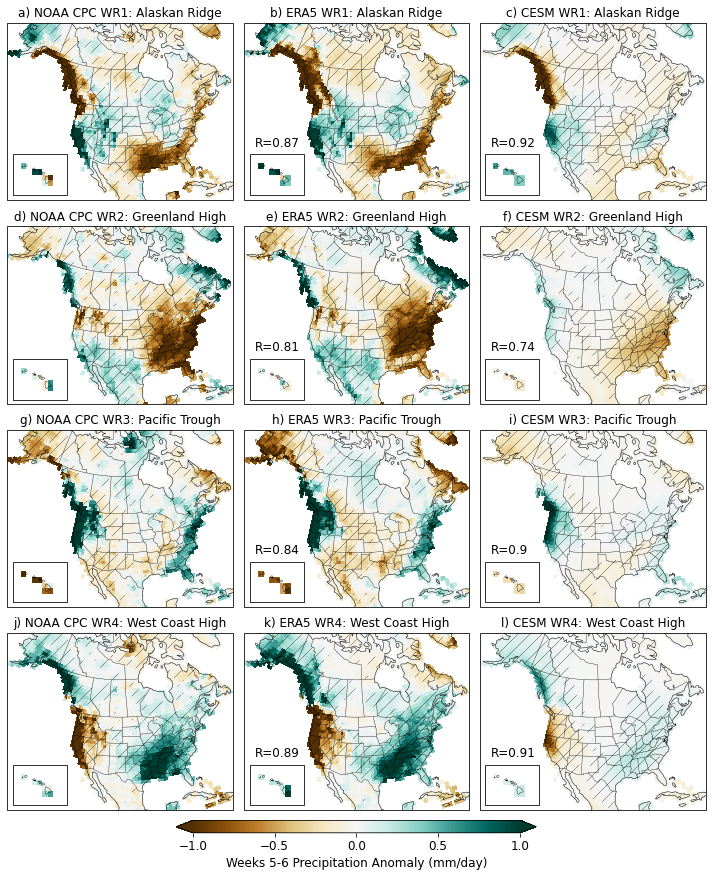

In [14]:
vmin=-1
vmax=1

proj = ccrs.LambertConformal(central_latitude = 39, 
                             central_longitude = -105, 
                             standard_parallels = (33, 45))

lons, lats = np.meshgrid(ds_pr['lon'].values, ds_pr['lat'].values)

# ---

fig, axs = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(10,11.5))

# ---

pm = axs[0][0].pcolormesh(lons, lats, ds_pr['wr1_ncpc'].values, 
                          transform=ccrs.PlateCarree(), 
                          vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][0].contourf(lons, lats, np.where((
    ds_pr['wr1_ncpc'].values<=ds_pr['wr1_ncpc_005'].values)|(
    ds_pr['wr1_ncpc'].values>=ds_pr['wr1_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][0].set_title(f'a) NOAA CPC WR1: Alaskan Ridge', fontsize=12)
axs[0][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[1][0].pcolormesh(lons, lats, ds_pr['wr2_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][0].contourf(lons, lats, np.where((
    ds_pr['wr2_ncpc'].values<=ds_pr['wr2_ncpc_005'].values)|(
    ds_pr['wr2_ncpc'].values>=ds_pr['wr2_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][0].set_title(f'd) NOAA CPC WR2: Greenland High', fontsize=12)
axs[1][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[2][0].pcolormesh(lons, lats, ds_pr['wr3_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][0].contourf(lons, lats, np.where((
    ds_pr['wr3_ncpc'].values<=ds_pr['wr3_ncpc_005'].values)|(
    ds_pr['wr3_ncpc'].values>=ds_pr['wr3_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][0].set_title(f'g) NOAA CPC WR3: Pacific Trough', fontsize=12)
axs[2][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[3][0].pcolormesh(lons, lats, ds_pr['wr4_ncpc'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][0].contourf(lons, lats, np.where((
    ds_pr['wr4_ncpc'].values<=ds_pr['wr4_ncpc_005'].values)|(
    ds_pr['wr4_ncpc'].values>=ds_pr['wr4_ncpc_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][0].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][0].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][0].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][0].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][0].set_title(f'j) NOAA CPC WR4: West Coast High', fontsize=12)
axs[3][0].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.0225, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_ncpc'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

# ---

axs[0][1].pcolormesh(lons, lats, ds_pr['wr1_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][1].contourf(lons, lats, np.where((
    ds_pr['wr1_era5'].values<=ds_pr['wr1_era5_005'].values)|(
    ds_pr['wr1_era5'].values>=ds_pr['wr1_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][1].set_title(f'b) ERA5 WR1: Alaskan Ridge', fontsize=12)
axs[0][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr1_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr1_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr1_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[0][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][1].pcolormesh(lons, lats, ds_pr['wr2_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][1].contourf(lons, lats, np.where((
    ds_pr['wr2_era5'].values<=ds_pr['wr2_era5_005'].values)|(
    ds_pr['wr2_era5'].values>=ds_pr['wr2_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][1].set_title(f'e) ERA5 WR2: Greenland High', fontsize=12)
axs[1][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr2_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr2_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr2_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[1][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][1].pcolormesh(lons, lats, ds_pr['wr3_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][1].contourf(lons, lats, np.where((
    ds_pr['wr3_era5'].values<=ds_pr['wr3_era5_005'].values)|(
    ds_pr['wr3_era5'].values>=ds_pr['wr3_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][1].set_title(f'h) ERA5 WR3: Pacific Trough', fontsize=12)
axs[2][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr3_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr3_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr3_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[2][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][1].pcolormesh(lons, lats, ds_pr['wr4_era5'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][1].contourf(lons, lats, np.where((
    ds_pr['wr4_era5'].values<=ds_pr['wr4_era5_005'].values)|(
    ds_pr['wr4_era5'].values>=ds_pr['wr4_era5_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][1].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][1].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][1].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][1].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][1].set_title(f'k) ERA5 WR4: West Coast High', fontsize=12)
axs[3][1].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.3525, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_era5'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr4_ncpc'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr4_ncpc'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr4_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[3][1].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[0][2].pcolormesh(lons, lats, ds_pr['wr1_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[0][2].contourf(lons, lats, np.where((
    ds_pr['wr1_cesm'].values<=ds_pr['wr1_cesm_005'].values)|(
    ds_pr['wr1_cesm'].values>=ds_pr['wr1_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[0][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[0][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[0][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[0][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[0][2].set_title(f'c) CESM WR1: Alaskan Ridge', fontsize=12)
axs[0][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.7475, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr1_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr1_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr1_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr1_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[0][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[1][2].pcolormesh(lons, lats, ds_pr['wr2_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[1][2].contourf(lons, lats, np.where((
    ds_pr['wr2_cesm'].values<=ds_pr['wr2_cesm_005'].values)|(
    ds_pr['wr2_cesm'].values>=ds_pr['wr2_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[1][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[1][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[1][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[1][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[1][2].set_title(f'f) CESM WR2: Greenland High', fontsize=12)
axs[1][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.5, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr2_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr2_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr2_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr2_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[1][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[2][2].pcolormesh(lons, lats, ds_pr['wr3_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[2][2].contourf(lons, lats, np.where((
    ds_pr['wr3_cesm'].values<=ds_pr['wr3_cesm_005'].values)|(
    ds_pr['wr3_cesm'].values>=ds_pr['wr3_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[2][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[2][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[2][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[2][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[2][2].set_title(f'i) CESM WR3: Pacific Trough', fontsize=12)
axs[2][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.255, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr3_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr3_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr3_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr3_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[2][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

axs[3][2].pcolormesh(lons, lats, ds_pr['wr4_cesm'].values, 
                     transform=ccrs.PlateCarree(), 
                     vmin=vmin, vmax=vmax, cmap='BrBG')

axs[3][2].contourf(lons, lats, np.where((
    ds_pr['wr4_cesm'].values<=ds_pr['wr4_cesm_005'].values)|(
    ds_pr['wr4_cesm'].values>=ds_pr['wr4_cesm_995'].values), 
         1., np.nan),
                   transform=ccrs.PlateCarree(), colors='none',
                   hatches=['//'], zorder=100)

axs[3][2].coastlines(resolution='110m', facecolor='none', color='k', linewidth=0.5, zorder=10)
axs[3][2].add_feature(STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
axs[3][2].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
axs[3][2].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

axs[3][2].set_title(f'l) CESM WR4: West Coast High', fontsize=12)
axs[3][2].margins(x=0,y=0)

map_extent = (-162, -152, 17, 24)
axes_extent = (0.678, 0.01, 0.075, 0.075)
add_insetmap(axes_extent, map_extent, lons, lats, ds_pr['wr4_cesm'].values, 
             vmin=vmin, vmax=vmax, cmap='BrBG')

nan_indx = np.argwhere(np.isnan(ds_pr['wr4_cesm'].values.flatten()))
data1_tmp = np.delete(ds_pr['wr4_cesm'].values.flatten(), nan_indx)
data2_tmp = np.delete(ds_pr['wr4_era5'].values.flatten(), nan_indx)

nan_indx = np.argwhere(np.isnan(data2_tmp))
data2_tmp = np.delete(data2_tmp, nan_indx)
data1_tmp = np.delete(data1_tmp, nan_indx)

r = np.around(stats.pearsonr(data1_tmp,data2_tmp)[0],2)

axs[3][2].annotate(f'R={r}',xy=(0.05,0.3),xycoords='axes fraction',zorder=100,fontsize=12)

# ---

cbar_ax = fig.add_axes([0.25, -0.01, 0.5, 0.015])

ticks_1 = [-1,-0.5,0,0.5,1]
cbar = fig.colorbar(pm, cax=cbar_ax, ticks=ticks_1[:], 
                    orientation='horizontal', extend='both')

cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Weeks 5-6 Precipitation Anomaly (mm/day)', fontsize=12)

# ---

plt.tight_layout()
plt.savefig(f"fig_wk56_pr.png", bbox_inches='tight', dpi=500)
plt.show()

# ---